Нейроэволюционные вычисления

 Практическая работа №1

 Преподаватель Григорьев Д.С.

 Студент Леонова Е.Д.

 Группа 8ВМ42

 2025

**Алгоритм SANE (Symbiotic, Adaptive Neuro-Evolution)** — это метод эволюции нейронных сетей, при котором:

* эволюционируются отдельные нейроны, а не вся сеть целиком;

* нейроны случайно комбинируются в полные сети;

* каждая комбинация оценивается в среде (в нашем случае — посадка лунохода);

* на основе оценок нейронов проводится естественный отбор.

## 1. Установка библиотек

In [ ]:
!apt install swig -y -q
!pip install gymnasium[box2d] -q

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,202 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126319 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ..

## 2. Импорт библиотек и инициализация среды

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

## 3. Определение нейрона

In [ ]:
class Neuron:
    def __init__(self, input_dim):
        self.weights = np.random.uniform(-1, 1, input_dim)
        self.bias = np.random.uniform(-1, 1)
        self.fitness = 0

    def activate(self, x):
        return np.tanh(np.dot(self.weights, x) + self.bias)

    def mutate(self, mutation_strength=0.02):
        self.weights += np.random.randn(len(self.weights)) * mutation_strength
        self.bias += np.random.randn() * mutation_strength

## 4. Построение сети

In [ ]:
class Network:
    def __init__(self, input_dim, hidden_neurons, output_dim):
        self.input_dim = input_dim
        self.hidden = hidden_neurons  # список объектов Neuron
        self.output_weights = np.random.uniform(-1, 1, (output_dim, len(hidden_neurons)))
        self.output_biases = np.random.uniform(-1, 1, output_dim)

    def forward(self, x):
        hidden_out = np.array([n.activate(x) for n in self.hidden])
        out = np.dot(self.output_weights, hidden_out) + self.output_biases
        return np.argmax(out)  # выбираем действие

## 5. Генерация популяции нейронов

In [ ]:
def initialize_population(n_neurons, input_dim):
    return [Neuron(input_dim) for _ in range(n_neurons)]

## 6. Создание случайной сети

In [ ]:
def create_random_network(neurons, input_dim, hidden_size, output_dim):
    hidden_neurons = random.sample(neurons, hidden_size)
    return Network(input_dim, hidden_neurons, output_dim)

## 7. Оценка сети

In [ ]:
def evaluate_network(network, n_episodes=3): # Оцениваем по нескольким эпизодам
    total_rewards = []
    final_states = []
    episode_states_history = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        current_episode_states = [] # История состояний для текущего эпизода

        while not done:
            current_episode_states.append(state) # Сохраняем текущее состояние
            action = network.forward(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            if done:
                final_state = state # Сохраняем финальное состояние

        total_rewards.append(episode_reward)
        final_states.append(final_state)
        episode_states_history.append(current_episode_states) # Сохраняем историю состояний

    # Возвращаем среднюю награду, список финальных состояний и историю состояний
    return np.mean(total_rewards), final_states, episode_states_history

## 8. Эволюция (обновление фитнеса, отбор, мутация)

In [ ]:
import copy

def evolve(neurons, n_networks, hidden_size, input_dim, output_dim, mutation_strength=0.02):
    # Сброс фитнеса всех нейронов перед началом нового поколения
    for neuron in neurons:
        neuron.fitness = 0
        neuron._generation_fitness_contributions = []
        neuron._generation_landing_scores = []

    networks_data = []
    # Создание и оценка сетей
    for _ in range(n_networks):
        # Случайная выборка нейронов для создания скрытого слоя сети
        hidden_neurons = random.sample(neurons, hidden_size)
        net = Network(input_dim, hidden_neurons, output_dim)
        # Оценка сети: получаем среднюю награду, список финальных состояний и историю состояний
        avg_reward, final_states, episode_states_history = evaluate_network(net)
        networks_data.append((net, avg_reward, final_states, episode_states_history))

        # Расчет посадочного балла на основе финальных состояний и истории состояний для каждого эпизода
        episode_landing_scores = []
        for i, final_state in enumerate(final_states):
            landing_score = 0
            states_history = episode_states_history[i]

            if final_state is not None:

                # Награда за успешное приземление (если средняя награда высокая для сети)
                if avg_reward > 180: # Порог для бонуса
                     landing_score += avg_reward * 1.8 # Множитель

                # Штраф за падение (если средняя награда очень низкая)
                if avg_reward < -120: # Порог для штрафа
                    landing_score += avg_reward * 0.8

                # Штраф за отклонение от центра посадочной площадки по горизонтали (в финальном состоянии)
                landing_score -= abs(final_state[0]) * 12

                # Штраф за большую вертикальную скорость при приземлении (движение вниз)
                landing_score -= abs(min(0, final_state[3])) * 12

                # Штраф за большую угловую скорость (вращение)
                landing_score -= abs(final_state[5]) * 10

                # Бонус за контакт с землей одной или обеими ногами
                if final_state[6] > 0 or final_state[7] > 0:
                    landing_score += 40
                # Дополнительный бонус за контакт обеими ногами
                if final_state[6] > 0 and final_state[7] > 0:
                     landing_score += 80

            # Добавляем компоненты на основе истории состояний:
            if states_history:
                # Поощрение стабильности (низкие скорости и угловая скорость на протяжении эпизода)
                # Суммируем штрафы за высокие значения на каждом шаге
                for state in states_history:
                    # Штраф за высокую горизонтальную скорость
                    landing_score -= abs(state[2]) * 0.05
                    # Штраф за высокую вертикальную скорость
                    landing_score -= abs(state[3]) * 0.05
                    # Штраф за высокую угловую скорость
                    landing_score -= abs(state[5]) * 0.03

                # Поощрение нахождения над зоной посадки (между флагами)
                # Бонус, если x-координата находится в пределах целевой зоны (-0.2 до 0.2)
                landing_zone_x_min = -0.2
                landing_zone_x_max = 0.2
                for state in states_history:
                    if landing_zone_x_min < state[0] < landing_zone_x_max:
                        landing_score += 0.1 # Небольшой бонус за каждый шаг в зоне

            episode_landing_scores.append(landing_score)

        # Усредняем посадочный балл по всем эпизодам для этой сети
        avg_landing_score = np.mean(episode_landing_scores) if episode_landing_scores else 0

        # Накопление вкладов в фитнес и усредненных посадочных очков для каждого нейрона
        for neuron in hidden_neurons:
             neuron._generation_fitness_contributions.append(avg_reward)
             neuron._generation_landing_scores.append(avg_landing_score)


    # Расчет итогового фитнеса для каждого нейрона
    for neuron in neurons:
        combined_scores = []
        # Объединяем среднюю награду и средний посадочный балл для каждой сети
        for avg_reward, avg_landing_score in zip(neuron._generation_fitness_contributions, neuron._generation_landing_scores):
             # Взвешенная комбинация средней награды и среднего посадочного балла (вес посадочного балла 0.6)
             combined_score = avg_reward + avg_landing_score * 0.6
             combined_scores.append(combined_score)

        if combined_scores:
            # Фитнес нейрона - среднее значение всех комбинированных оценок сетей, в которых он участвовал
            neuron.fitness = np.mean(combined_scores)
        else:
            # Если нейрон не был использован ни в одной сети, присваиваем ему низкий фитнес
            neuron.fitness = -2000

    # Отбор: сортировка нейронов по фитнесу
    neurons = sorted(neurons, key=lambda n: n.fitness, reverse=True)

    # Определение количества элитных нейронов и пула размножения
    # Например, 2% элиты, минимум 1
    elite_count = max(1, len(neurons) // 50)
    breeding_pool_count = max(1, len(neurons) * 3 // 10) # 30% для пула размножения

    # Создание новой популяции
    new_neurons = []

    # Добавление элитных нейронов (без мутаций)
    elite_neurons = neurons[:elite_count]
    new_neurons.extend(copy.deepcopy(elite_neurons))

    # Выбор нейронов для пула размножения (те же лучшие, из которых берется и элита)
    breeding_pool = neurons[:breeding_pool_count]

    # Создание остальной части популяции путем мутации из пула размножения
    while len(new_neurons) < len(neurons):
        parent = random.choice(breeding_pool)
        child = copy.deepcopy(parent)
        child.mutate(mutation_strength=mutation_strength)
        new_neurons.append(child)

    return new_neurons

## 9. Основной цикл обучения

## Параметры обучения SANE

Перед запуском основного цикла обучения определяются ключевые параметры, которые контролируют процесс эволюции нейронов и производительность алгоритма SANE:

*   **`n_generations`**: Количество поколений эволюции. Определяет, сколько раз будет происходить процесс отбора, мутации и оценки нейронов. Чем больше поколений, тем дольше обучение, но потенциально лучше результат.
*   **`population_size`**: Общий размер популяции нейронов. Это количество отдельных нейронов, которые участвуют в процессе эволюции. Большая популяция увеличивает разнообразие, но требует больше ресурсов.
*   **`networks_per_generation`**: Количество случайных сетей, создаваемых и оцениваемых в каждом поколении. Каждая сеть формируется путем случайной выборки нейронов из популяции. Оценка этих сетей используется для определения фитнеса отдельных нейронов.
*   **`hidden_size`**: Количество нейронов, которые случайным образом выбираются из популяции для формирования скрытого слоя каждой сети.
*   **`mutation_strength`**: Коэффициент, определяющий силу мутации. Контролирует, насколько сильно изменяются веса и смещения нейронов во время мутации.

In [ ]:
n_generations = 300
population_size = 100
networks_per_generation = 1000
hidden_size = 50
mutation_strength = 0.01


neurons = initialize_population(population_size, state_dim)
fitness_history = []

for generation in range(n_generations):
    neurons = evolve(neurons,
                     networks_per_generation,
                     hidden_size,
                     state_dim,
                     action_dim,
                     mutation_strength)
    best_neurons = sorted(neurons, key=lambda n: n.fitness, reverse=True)[:hidden_size]
    best_network = Network(state_dim, best_neurons, action_dim)
    # Оцениваем лучшую сеть по нескольким эпизодам для отслеживания прогресса
    best_fitness, _, _ = evaluate_network(best_network, n_episodes=5) # Оцениваем по 5 эпизодам
    fitness_history.append(best_fitness)
    print(f"Поколение {generation + 1} | Лучшая награда: {best_fitness:.2f}")

## 10. Визуализация обучения

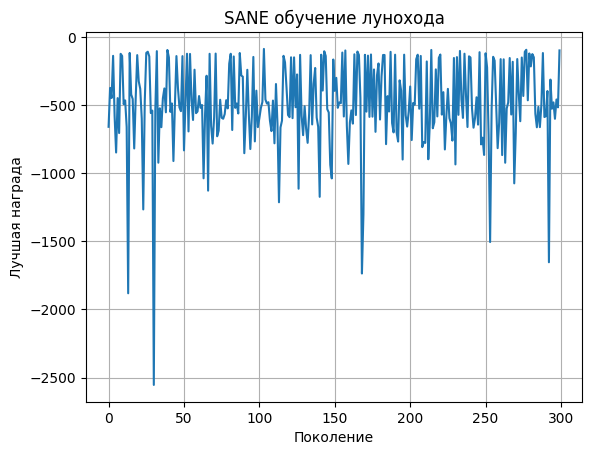

In [ ]:
plt.plot(fitness_history)
plt.xlabel("Поколение")
plt.ylabel("Лучшая награда")
plt.title("SANE обучение лунохода")
plt.grid()
plt.show()

## 11. Запуск финального эпизода

In [ ]:
from IPython.display import HTML, display
from matplotlib import animation
import matplotlib.pyplot as plt

def visualize_episode(network):
    frames = []
    # Инициализируем окружение с render_mode="rgb_array"
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    state, _ = env.reset()
    done = False
    while not done:
        frame = env.render()
        frames.append(frame)
        action = network.forward(state)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    env.close() # Закрываем окружение после использования

    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    display(HTML(ani.to_jshtml()))
    plt.close(fig)


# Проверяем, существует ли best_network
try:
    best_network
except NameError:
    print("Переменная 'best_network' не найдена. Убедитесь, что ячейка с обучением была выполнена.")
else:
    visualize_episode(best_network)

## 12. Визуализация активности скрытых нейронов

In [ ]:
def visualize_neuron_activations(network):
    state, _ = env.reset()
    done = False
    activations = [[] for _ in network.hidden]

    while not done:
        # считаем активации
        for i, neuron in enumerate(network.hidden):
            activations[i].append(neuron.activate(state))
        action = network.forward(state)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    plt.figure(figsize=(10, 5))
    for i, neuron_act in enumerate(activations):
        plt.plot(neuron_act, label=f"Нейрон {i}")
    plt.xlabel("Шаг")
    plt.ylabel("Активация (tanh)")
    plt.title("Активации нейронов скрытого слоя")
    plt.legend()
    plt.grid()
    plt.show()

## Сравнение эпизодов

Запуск случайной сети ДО обучения:


Запуск лучшей сети ПОСЛЕ обучения:


Активации нейронов лучшей сети:


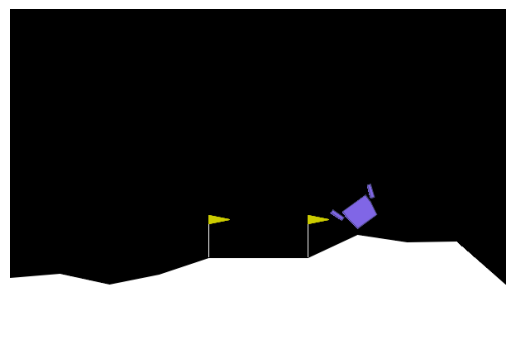

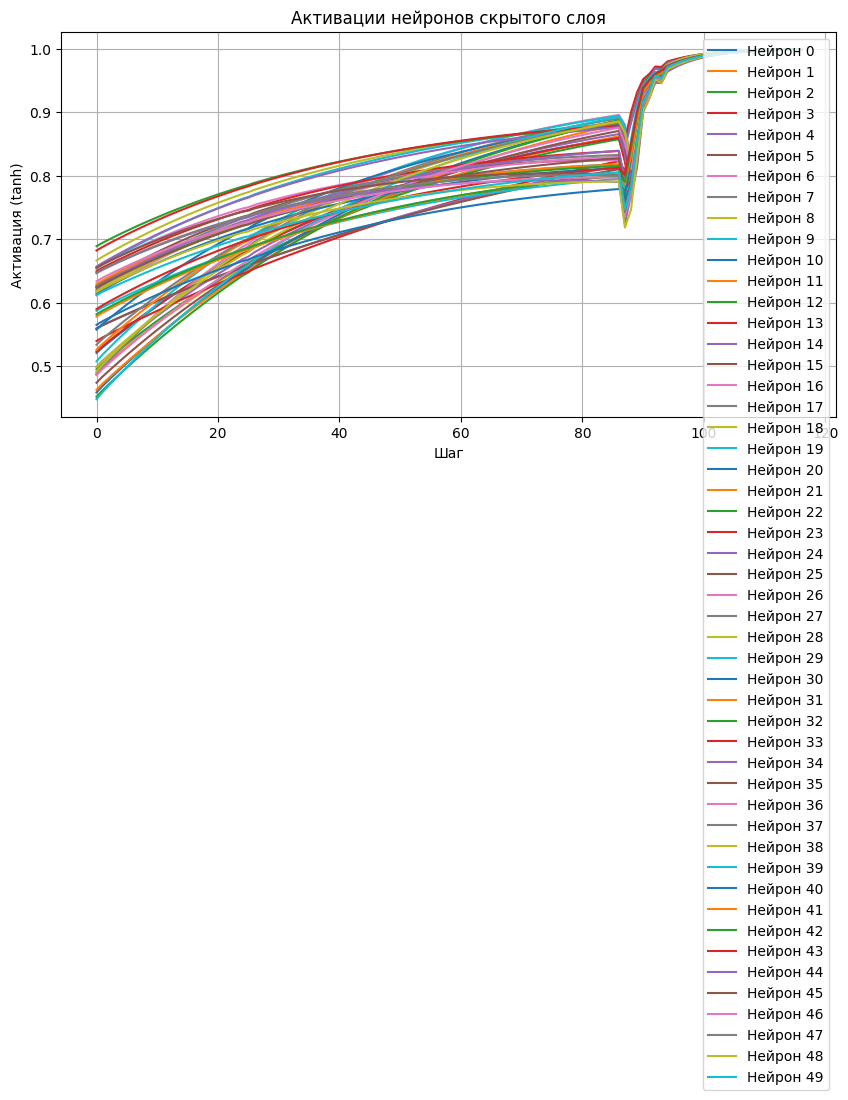

In [ ]:
# случайная сеть до обучения
initial_hidden = random.sample(neurons, hidden_size)
initial_network = Network(state_dim, initial_hidden, action_dim)

print("Запуск случайной сети ДО обучения:")

initial_render_env = gym.make("LunarLander-v3", render_mode="rgb_array")
def visualize_initial_episode(network, render_env):
    frames = []
    state, _ = render_env.reset()
    done = False
    while not done:
        frame = render_env.render()
        frames.append(frame)
        action = network.forward(state)
        state, _, terminated, truncated, _ = render_env.step(action)
        done = terminated or truncated
    render_env.close()

    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    display(HTML(ani.to_jshtml()))

visualize_initial_episode(initial_network, initial_render_env)


print("Запуск лучшей сети ПОСЛЕ обучения:")
visualize_episode(best_network)

print("Активации нейронов лучшей сети:")
visualize_neuron_activations(best_network)

In [ ]:
n_generations = 300
population_size = 100
networks_per_generation = 350
hidden_size = 50
mutation_strength = 0.01


neurons = initialize_population(population_size, state_dim)
fitness_history = []
best_overall_network = None
best_overall_fitness = -np.inf

for generation in range(n_generations):
    neurons = evolve(neurons,
                     networks_per_generation,
                     hidden_size,
                     state_dim,
                     action_dim,
                     mutation_strength)
    # Получаем лучшую сеть в текущем поколении на основе фитнеса нейронов
    best_neurons_in_generation = sorted(neurons, key=lambda n: n.fitness, reverse=True)[:hidden_size]
    current_best_network = Network(state_dim, best_neurons_in_generation, action_dim)

    current_best_fitness, _, _ = evaluate_network(current_best_network, n_episodes=5)

    fitness_history.append(current_best_fitness)
    print(f"Поколение {generation + 1} | Лучшая награда в поколении: {current_best_fitness:.2f}")

    # Проверяем, является ли текущая лучшая сеть лучшей за все поколения
    if current_best_fitness > best_overall_fitness:
        best_overall_fitness = current_best_fitness
        best_overall_network = Network(state_dim, copy.deepcopy(best_neurons_in_generation), action_dim)
        print(f"              Новая лучшая награда за все поколения: {best_overall_fitness:.2f}")


# best_overall_network будет содержать лучшую модель
best_network = best_overall_network

Поколение 1 | Лучшая награда в поколении: -661.36
              Новая лучшая награда за все поколения: -661.36
Поколение 2 | Лучшая награда в поколении: -376.17
              Новая лучшая награда за все поколения: -376.17
Поколение 3 | Лучшая награда в поколении: -450.20
Поколение 4 | Лучшая награда в поколении: -140.82
              Новая лучшая награда за все поколения: -140.82
Поколение 5 | Лучшая награда в поколении: -581.84
Поколение 6 | Лучшая награда в поколении: -849.82
Поколение 7 | Лучшая награда в поколении: -450.92
Поколение 8 | Лучшая награда в поколении: -707.03
Поколение 9 | Лучшая награда в поколении: -126.16
              Новая лучшая награда за все поколения: -126.16
Поколение 10 | Лучшая награда в поколении: -141.86
Поколение 11 | Лучшая награда в поколении: -495.31
Поколение 12 | Лучшая награда в поколении: -467.66
Поколение 13 | Лучшая награда в поколении: -662.43
Поколение 14 | Лучшая награда в поколении: -1882.28
Поколение 15 | Лучшая награда в поколении: -119.63